In [2]:
import pandas as pd
import torch
import torch_geometric as pyg

from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.loader import NeighborLoader

import pandas as pd
import networkx as nx
import numpy as np
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns


from tqdm import tqdm
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

/opt/homebrew/anaconda3/envs/network_ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_books = pd.read_csv('../data/books.csv')[['book_id', 'title', 'authors']]    # TODO: think about using also the columns
df_ratings = pd.read_csv('../data/ratings.csv')

In [39]:
len(df_ratings)

5976479

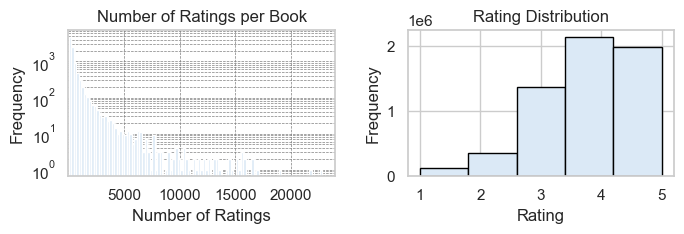

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_palette("Blues")  # or use a custom color palette

df_books_merged = df_books.merge(df_ratings.groupby('book_id').size().reset_index(name='n_ratings'), on='book_id')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5))  # adjust the figure size

# Plot the number of ratings per book (log scale)
axes[0].hist(df_books_merged['n_ratings'], bins=100, log=True, linewidth=1)
axes[0].set_title('Number of Ratings per Book')
axes[0].set_xlabel('Number of Ratings')
axes[0].set_ylabel('Frequency')
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
axes[0].set_xlim(1, None)  # set the lower limit of x-axis to 1

# Plot the rating distribution
axes[1].hist(df_ratings['rating'], bins=5, edgecolor='black')
axes[1].set_title('Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


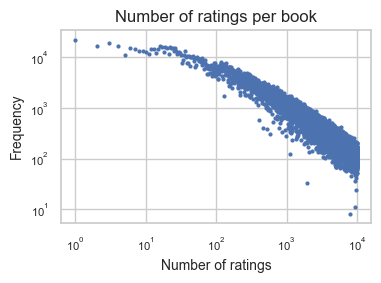

In [38]:
# order books by number of ratings
sns.set(style="whitegrid")
df_books_merged = df_books.merge(df_ratings.groupby('book_id').size().reset_index(name='n_ratings'), on='book_id')


# Create the plot with a specific figure size
plt.figure(figsize=(4, 2.5))

# Plot the number of ratings on a log scale
plt.scatter(df_books_merged.index, df_books_merged['n_ratings'], s=4, marker='o', color='b')
plt.xscale('log')
plt.yscale('log')

# Set the title and labels with a larger font size
plt.title('Number of ratings per book', fontsize=12)
plt.xlabel('Number of ratings', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

# Adjust tick parameters for larger font size
plt.tick_params(axis='both', which='major', labelsize=8)

# Save the plot as a PDF with tight bounding box
plt.savefig("plots/number_of_reviews_per_book.pdf", bbox_inches='tight')

# Show the plot (optional, for visual verification)
plt.show()

# Plot the rating distribution
axes[1].hist(df_ratings['rating'], bins=5, edgecolor='black')
axes[1].set_title('Rating Distribution')
axes[1].set_xlabel('Rating')
axes[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


It's a power law!!

In [4]:
df_books_merged.head(10)

,book_id,title,authors,n_ratings
0,1,"The Hunger Games (The Hunger Games, #1)",Suzanne Collins,22806
1,2,Harry Potter and the Sorcerer's Stone (Harry P...,"J.K. Rowling, Mary GrandPré",21850
2,3,"Twilight (Twilight, #1)",Stephenie Meyer,16931
3,4,To Kill a Mockingbird,Harper Lee,19088
4,5,The Great Gatsby,F. Scott Fitzgerald,16604
5,6,The Fault in Our Stars,John Green,11264
6,7,The Hobbit,J.R.R. Tolkien,15558
7,8,The Catcher in the Rye,J.D. Salinger,14472
8,9,"Angels & Demons (Robert Langdon, #1)",Dan Brown,13451
9,10,Pride and Prejudice,Jane Austen,13445


Text(0.5, 1.0, 'Number of reviews per user')

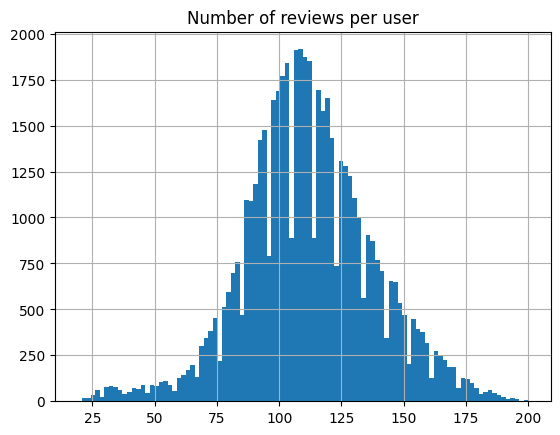

In [5]:
# plot the number of reviews per user
df_ratings.groupby('user_id').size().hist(bins=100)
plt.title('Number of reviews per user')

In [13]:
# print the number of connected components
G = nx.Graph()
G.add_edges_from(df_ratings[['user_id', 'book_id']].values)
print(nx.number_connected_components(G))

1


Text(0.5, 1.0, 'Rating distribution')

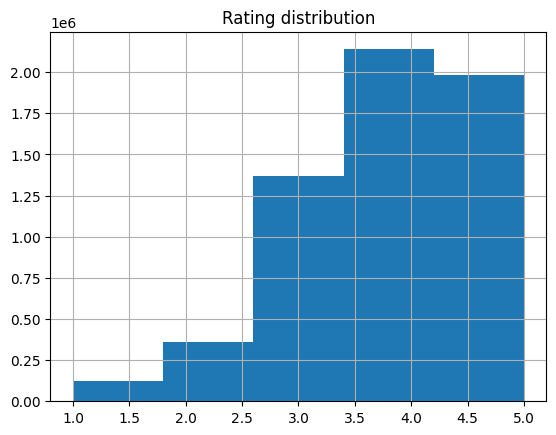

In [24]:
df_ratings.rating.hist(bins=5)
plt.title('Rating distribution')

Text(0.5, 1.0, 'Mean rating per book')

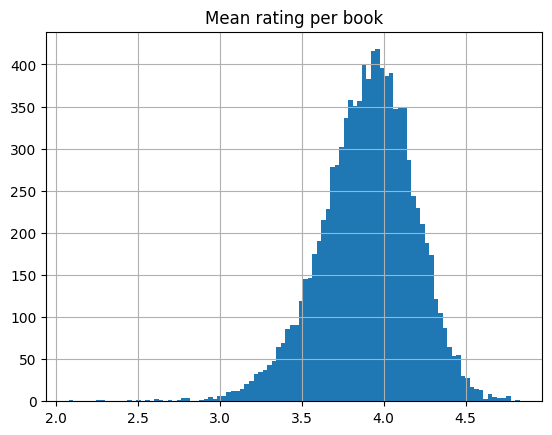

In [32]:
# are popular books rated higher?
mean_rating = df_ratings.groupby('book_id')['rating'].mean()
mean_rating.hist(bins=100)
plt.title('Mean rating per book')

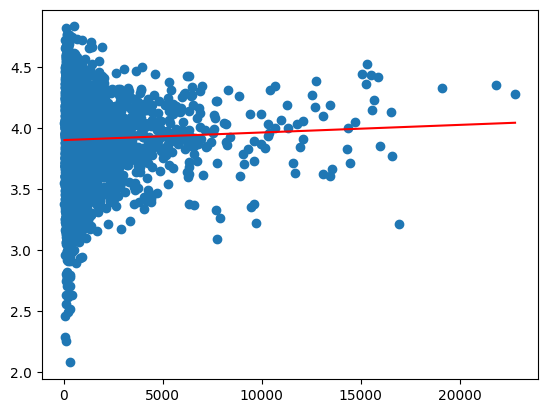

In [36]:
# are popular books rated higher? plot a linear line fitted on the mean ratings and number of ratings
plt.scatter(df_books_merged['n_ratings'], mean_rating)

m, b = np.polyfit(df_books_merged['n_ratings'], mean_rating, 1) # 1 is the degree of the polynomial (linear)
plt.plot(df_books_merged['n_ratings'], m*df_books_merged['n_ratings'] + b, color='red') # Add the regression line

plt.title('Mean rating per book vs number of ratings')

<Axes: >

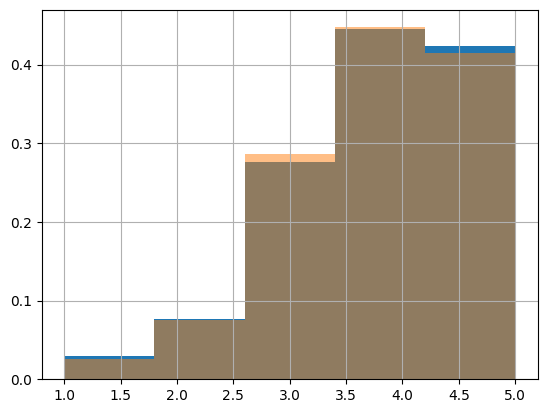

In [25]:
sampled_users = np.random.choice(df_ratings.user_id.unique(), 2000)
df_ratings_sampled = df_ratings[df_ratings.user_id.isin(sampled_users)]
df_ratings_sampled.rating.hist(bins=5, density=True)
df_ratings.rating.hist(bins=5, density=True, alpha=0.5)

Text(0.5, 1.0, 'Number of reviews per user')

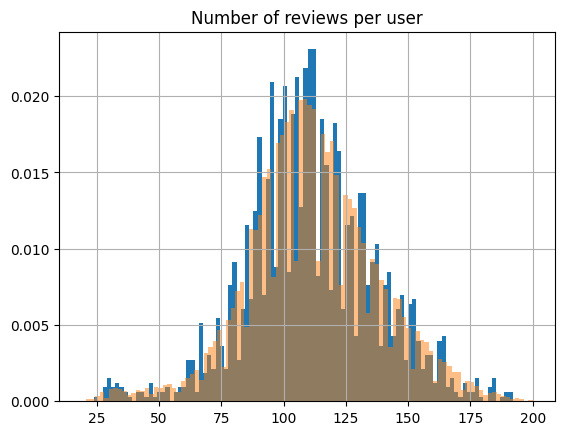

In [27]:
df_ratings_sampled.groupby('user_id').size().hist(bins=100, density=True)
df_ratings.groupby('user_id').size().hist(bins=100, density=True, alpha=0.5)
plt.title('Number of reviews per user')

There is almost no correlation between the number of ratings and the review. But as the number of ratings increase the variance of the rating decrease

## Ideas

Our aim is to create a recommender system which given a set of books which the user has rated it find a book which he hasn't read but he's most likely to like more. Most of the ratings are between 3.5 and 4.5 which make the learning more complicated. 

The most rated books are rated by almost half the user in our dataset, so they will be suggested with high probability to the users who haven't read them. This is why we should try to increase the diversity of the suggestions. 

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

df_books = pd.read_csv('../data/books.csv')

<Axes: xlabel='authors'>

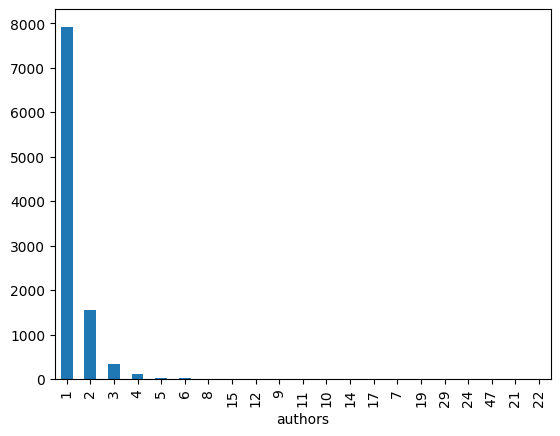

In [2]:
df_books.authors.str.split(',').apply(len).value_counts().plot(kind='bar')

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.]),
 [Text(-1000.0, 0, 'Joe McGinniss'),
  Text(0.0, 0, 'James Patterson'),
  Text(1000.0, 0, ' Nora Roberts'),
  Text(2000.0, 0, ' Neil Smith'),
  Text(3000.0, 0, 'Marlo Morgan'),
  Text(4000.0, 0, 'Barbara Demick'),
  Text(5000.0, 0, 'Joyce Carol Oates'),
  Text(6000.0, 0, 'Rachael Ray'),
  Text(7000.0, 0, '')])

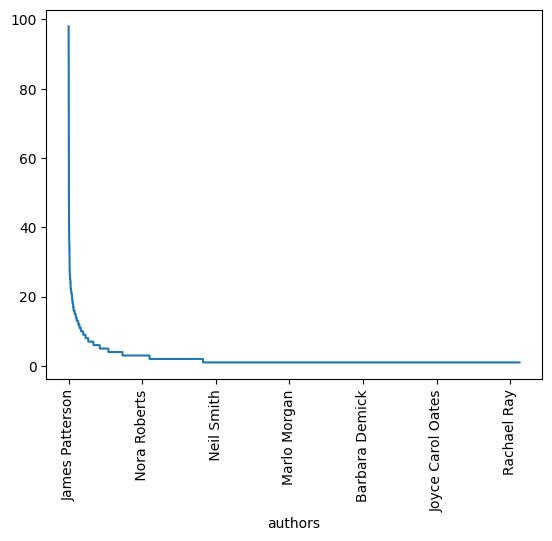

In [5]:
# get how many authors in total
authors = df_books.authors.str.split(',').explode()
authors.value_counts().plot()

# rotate x labels
plt.xticks(rotation=90)

<Axes: xlabel='language_code'>

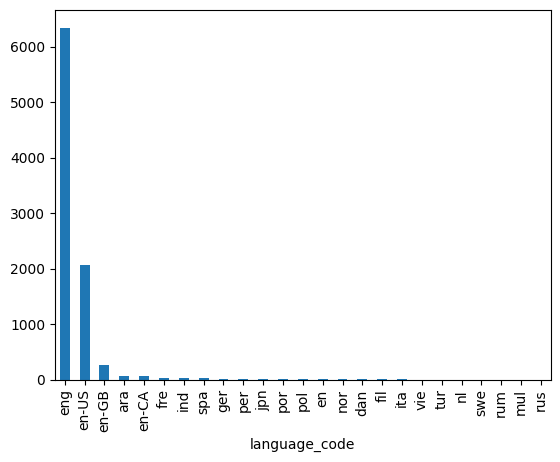

In [8]:
df_books.language_code.value_counts().plot(kind='bar')

In [9]:
df_book_tags = pd.read_csv('../data/book_tags.csv')

In [12]:
df_book_tags.tag_id.unique().shape

(34252,)

In [22]:
def map_user_book_ids(ratings_book_merged):
    """Makses user and book ids contiguous.

    Args:
        ratings_book_merged (_type_): _description_

    Returns:
        _type_: _description_
    """
    unique_user_id = ratings_book_merged['user_id'].unique()
    unique_user_id = pd.DataFrame(data={
        'user_id': unique_user_id, 
        'mapped_user_id': pd.RangeIndex(len(unique_user_id))
        })
    
    unique_book_id = ratings_book_merged['book_id'].unique()
    unique_book_id = pd.DataFrame(data={
        'book_id': unique_book_id,
        'mapped_book_id': pd.RangeIndex(len(unique_book_id))
        })

    ratings_book_merged = ratings_book_merged.merge(unique_user_id, on='user_id')
    ratings_book_merged = ratings_book_merged.merge(unique_book_id, on='book_id')

    return ratings_book_merged

In [23]:
def encode_string_array(array):
    unique_strings = array.unique()
    string_to_int = {string: i for i, string in enumerate(unique_strings)}
    int_array = np.vectorize(string_to_int.get)(array)
    return int_array

def build_edge_index(column1, column2):

    edge_index = torch.stack([
        torch.tensor(column1), 
        torch.tensor(column2)]
        , dim=0)
    return edge_index

In [52]:
from torch_geometric.data import HeteroData
import torch
import torch_geometric.transforms as T
import pandas as pd
import numpy as np

df_books = pd.read_csv('../data/books.csv')
df_ratings = pd.read_csv('../data/ratings.csv')


##### function starts ### 

ratings_book_merged = pd.merge(df_ratings, df_books, on='book_id')

# user and book ids aren't continguos, we need to map them to a contiguous range
ratings_book_merged = map_user_book_ids(ratings_book_merged)

data = HeteroData()
data['user'].x = ratings_book_merged['mapped_user_id'].unique()  # [num_users]
data['book'].x = ratings_book_merged['mapped_book_id'].unique()  # [num_books]


data['user', 'rates', 'book'].edge_index = build_edge_index(ratings_book_merged['mapped_user_id'], ratings_book_merged['mapped_book_id'])
rating = torch.from_numpy(ratings_book_merged['rating'].values).float()
data['user', 'rates', 'book'].edge_label = rating  # [num_ratings]

# Split the 'authors' column into lists
ratings_book_merged['single_authors'] = ratings_book_merged['authors'].str.split(', ').copy()
expanded_df = ratings_book_merged.explode('single_authors', ignore_index=True)
int_array = encode_string_array(expanded_df['single_authors'])
data['book', 'by', 'author'].edge_index = build_edge_index(expanded_df['mapped_book_id'].values, int_array)
data['author'].x = torch.tensor(np.unique(int_array))

int_array = encode_string_array(ratings_book_merged['language_code'])
data['book', 'written_in', 'language'].edge_index = build_edge_index(ratings_book_merged['mapped_book_id'].values, int_array)
data['language'].x = torch.tensor(np.unique(int_array))

# We also need to make sure to add the reverse edges from books to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
data = T.ToUndirected()(data)


In [53]:
data

HeteroData(
  user={ x=[53424] },
  book={ x=[10000] },
  author={ x=[5841] },
  language={ x=[26] },
  (user, rates, book)={
    edge_index=[2, 5976479],
    edge_label=[5976479],
  },
  (book, by, author)={ edge_index=[2, 7962940] },
  (book, written_in, language)={ edge_index=[2, 5976479] },
  (book, rev_rates, user)={
    edge_index=[2, 5976479],
    edge_label=[5976479],
  },
  (author, rev_by, book)={ edge_index=[2, 7962940] },
  (language, rev_written_in, book)={ edge_index=[2, 5976479] }
)

In [54]:
from torch_geometric.transforms import RandomLinkSplit

tfs = RandomLinkSplit(is_undirected=True, 
                    num_val=0.1,
                    num_test=0.1,
                    neg_sampling_ratio=0.0,
                    add_negative_train_samples=False,
                    edge_types=[('user', 'rates', 'book')],
                    rev_edge_types=[('book', 'rev_rates', 'user')],
                    )

train_data, val_data, test_data = tfs(data)


In [55]:
train_data

HeteroData(
  user={ x=[53424] },
  book={ x=[10000] },
  author={ x=[5841] },
  language={ x=[26] },
  (user, rates, book)={
    edge_index=[2, 4781185],
    edge_label=[4781185],
    edge_label_index=[2, 4781185],
  },
  (book, by, author)={ edge_index=[2, 7962940] },
  (book, written_in, language)={ edge_index=[2, 5976479] },
  (book, rev_rates, user)={
    edge_index=[2, 4781185],
    edge_label=[4781185],
  },
  (author, rev_by, book)={ edge_index=[2, 7962940] },
  (language, rev_written_in, book)={ edge_index=[2, 5976479] }
)

In [ ]:
eteroData(
  (user, rates, book)={
    edge_index=[2, 5976479],
    edge_label=[5976479],
  },
  (book, rev_rates, user)={
    edge_index=[2, 5976479],
    edge_label=[5976479],
  },
  (book, by, author)={ edge_index=[2, 7962940] },
  (book, written_in, language)={ edge_label=[2, 5976479] }
)